In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.decomposition import PCA
from collections import Counter
import tqdm

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import optuna
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_parquet('/kaggle/input/purple-hack/train_ai_comp_final_dp.parquet')

In [4]:
for col in data.columns:
    if data[col].dtype == 'int64':
        data[col] = data[col].astype('int32')
    elif data[col].dtype == 'float64':
        data[col] = data[col].astype('float32')
    elif data[col].dtype == 'object':
        if len(data[col].unique()) / len(data[col]) < 0.5:
            data[col] = data[col].astype('category')
        

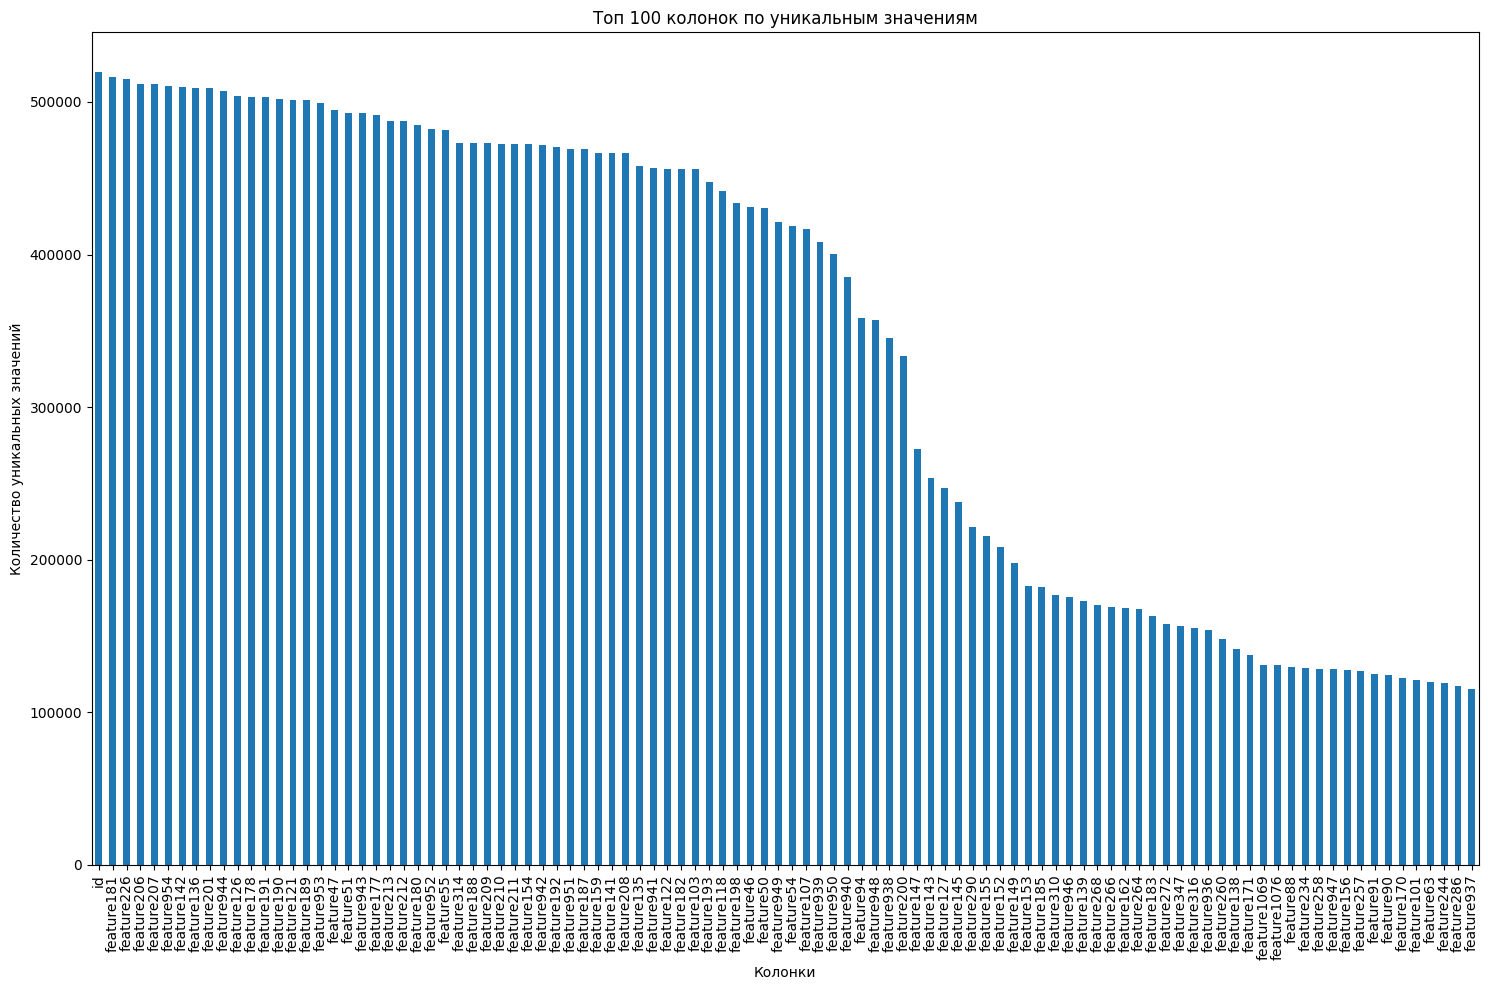

In [17]:
#1. Количество уникальных значений 
unique_counts = data.nunique().sort_values(ascending=False)

top_100_cols = unique_counts.head(100)

plt.figure(figsize=(15,10))
top_100_cols.plot(kind='bar')
plt.ylabel('Количество уникальных значений')
plt.xlabel('Колонки')
plt.title('Топ 100 колонок по уникальным значениям')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

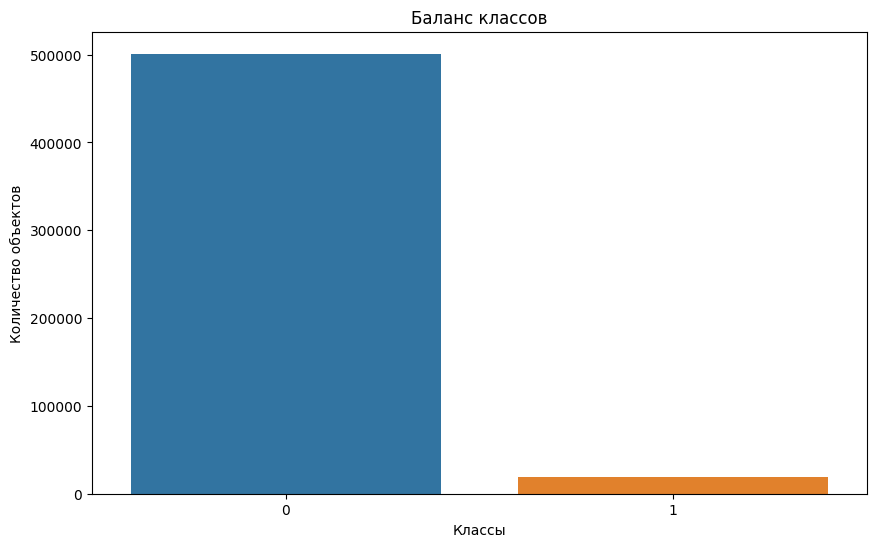

In [19]:
# соотношение классов
class_counts = data['target'].value_counts()


plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=data)
plt.xlabel('Классы')
plt.ylabel('Количество объектов')
plt.title('Баланс классов')
plt.show()

In [5]:
# Удаление фичей, которые коррелируют друг с другом больше, чем на 0.9
def get_correlated_feats(corr_matrix, feat_stats, greater_is_better=True, corr_threshold=0.9):
    cols = corr_matrix.columns.to_list()
    dropped = {col:0 for col in cols}
    for col in tqdm.tqdm(cols, desc='Get correlated features'):
        if dropped[col] == 0:
            columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col]) >= corr_threshold]
            if len(columns_to_check) > 1:
                print(f'{col} -> {columns_to_check}')
                if feat_stats is None:
                    bad_cols = columns_to_check[1:]
                else:
                    sel_stats = feat_stats.loc[columns_to_check]
                    if greater_is_better:
                        bad_cond = np.abs(sel_stats) < np.abs(sel_stats).max()
                    else:
                        bad_cond = np.abs(sel_stats) > np.abs(sel_stats).min()
                        
                    bad_cols = sel_stats[bad_cond].index.to_list()
                    norm_cols = sel_stats[~bad_cond].index.to_list()
                    if len(norm_cols) > 1:
                        for norm_col in norm_cols[1:]:
                            dropped[norm_col] += 1
                            
                for bad_col in bad_cols:
                    dropped[bad_col] += 1
                
    high_corr_cols = [c for c in dropped.keys() if dropped[c] > 0]
    return high_corr_cols

In [6]:
clean_df = data.copy()
nan_percentage = (clean_df == 0).mean()
cols_to_drop = list(nan_percentage[nan_percentage > 0.95].index)

ignore_features = ['id', 'target', 'sample_ml_new', 'feature756'] + cols_to_drop
print(len(ignore_features))
clean_df = clean_df.drop(columns=ignore_features)

corr_mx = pd.DataFrame(np.corrcoef(clean_df.values, rowvar=False), columns=clean_df.columns, index=clean_df.columns)

corr_feats = get_correlated_feats(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.95)
len(corr_feats)

194


Get correlated features:   7%|▋         | 61/886 [00:00<00:02, 310.09it/s]

feature1 -> ['feature1' 'feature812']
feature2 -> ['feature2' 'feature814']
feature3 -> ['feature3' 'feature933']
feature5 -> ['feature5' 'feature13' 'feature317' 'feature348' 'feature858'
 'feature860']
feature6 -> ['feature6' 'feature351' 'feature853' 'feature863']
feature7 -> ['feature7' 'feature8' 'feature10' 'feature11' 'feature14' 'feature15'
 'feature16' 'feature242' 'feature245' 'feature246' 'feature247'
 'feature248' 'feature249' 'feature259' 'feature267' 'feature598'
 'feature600' 'feature601' 'feature602' 'feature603' 'feature604'
 'feature608' 'feature609' 'feature610' 'feature611' 'feature612'
 'feature681' 'feature696']
feature12 -> ['feature12' 'feature347' 'feature859']
feature14 -> ['feature7' 'feature8' 'feature10' 'feature11' 'feature14' 'feature15'
 'feature242' 'feature245' 'feature246' 'feature247' 'feature248'
 'feature249' 'feature259' 'feature267' 'feature598' 'feature600'
 'feature601' 'feature602' 'feature603' 'feature604' 'feature608'
 'feature609' 'feature6

Get correlated features:  18%|█▊        | 158/886 [00:00<00:01, 430.12it/s]

feature73 -> ['feature73' 'feature132']
feature76 -> ['feature76' 'feature414']
feature83 -> ['feature83' 'feature421']
feature88 -> ['feature88' 'feature90']
feature92 -> ['feature92' 'feature312']
feature93 -> ['feature93' 'feature119' 'feature432' 'feature467']
feature96 -> ['feature96' 'feature129' 'feature130' 'feature134' 'feature313'
 'feature438' 'feature479' 'feature481' 'feature482' 'feature486']
feature103 -> ['feature103' 'feature135']
feature104 -> ['feature104' 'feature449']
feature113 -> ['feature113' 'feature458']
feature115 -> ['feature115' 'feature460']
feature121 -> ['feature121' 'feature126' 'feature201']
feature128 -> ['feature128' 'feature480']
feature136 -> ['feature136' 'feature142' 'feature206' 'feature207']
feature141 -> ['feature141' 'feature159']
feature161 -> ['feature161' 'feature512']
feature166 -> ['feature166' 'feature519']
feature167 -> ['feature167' 'feature520']


Get correlated features:  36%|███▌      | 318/886 [00:00<00:01, 506.37it/s]

feature188 -> ['feature188' 'feature314']
feature189 -> ['feature189' 'feature190']
feature190 -> ['feature189' 'feature190']
feature193 -> ['feature193' 'feature198']
feature196 -> ['feature196' 'feature549']
feature206 -> ['feature136' 'feature206' 'feature207']
feature208 -> ['feature208' 'feature209']
feature210 -> ['feature210' 'feature211']
feature212 -> ['feature212' 'feature213']
feature218 -> ['feature218' 'feature219']
feature219 -> ['feature218' 'feature219']
feature220 -> ['feature220' 'feature221' 'feature222' 'feature223']
feature232 -> ['feature232' 'feature235' 'feature236' 'feature237' 'feature238'
 'feature239' 'feature240' 'feature241' 'feature252' 'feature255'
 'feature256' 'feature263' 'feature271' 'feature579' 'feature580'
 'feature581' 'feature582' 'feature583' 'feature584' 'feature585'
 'feature586' 'feature589' 'feature590' 'feature591' 'feature592'
 'feature593' 'feature594' 'feature595' 'feature596' 'feature605'
 'feature606' 'feature607' 'feature613' 'featur

Get correlated features:  53%|█████▎    | 468/886 [00:01<00:00, 545.17it/s]

feature338 -> ['feature338' 'feature850']
feature339 -> ['feature339' 'feature852']
feature342 -> ['feature342' 'feature913']
feature343 -> ['feature343' 'feature912']
feature344 -> ['feature344' 'feature931']
feature345 -> ['feature345' 'feature914']
feature346 -> ['feature346' 'feature915']
feature347 -> ['feature12' 'feature347' 'feature859']
feature348 -> ['feature5' 'feature13' 'feature317' 'feature348' 'feature858'
 'feature860']
feature349 -> ['feature349' 'feature443' 'feature864']
feature350 -> ['feature350' 'feature865']
feature351 -> ['feature6' 'feature351' 'feature853' 'feature863']
feature352 -> ['feature352' 'feature866']
feature353 -> ['feature353' 'feature867']
feature354 -> ['feature354' 'feature899']
feature355 -> ['feature355' 'feature906']
feature356 -> ['feature356' 'feature900']
feature357 -> ['feature357' 'feature907']
feature358 -> ['feature358' 'feature901']
feature359 -> ['feature359' 'feature908']
feature360 -> ['feature16' 'feature17' 'feature360' 'feature3

Get correlated features:  86%|████████▌ | 758/886 [00:01<00:00, 919.97it/s]

feature591 -> ['feature232' 'feature235' 'feature236' 'feature237' 'feature238'
 'feature239' 'feature240' 'feature241' 'feature252' 'feature253'
 'feature254' 'feature255' 'feature256' 'feature263' 'feature271'
 'feature579' 'feature580' 'feature581' 'feature582' 'feature583'
 'feature584' 'feature585' 'feature586' 'feature589' 'feature590'
 'feature591' 'feature592' 'feature593' 'feature594' 'feature595'
 'feature596' 'feature605' 'feature606' 'feature607' 'feature613'
 'feature614' 'feature615']
feature632 -> ['feature632' 'feature641']
feature641 -> ['feature632' 'feature641']
feature675 -> ['feature675' 'feature676']
feature676 -> ['feature675' 'feature676']
feature691 -> ['feature495' 'feature691']
feature713 -> ['feature713' 'feature714']
feature716 -> ['feature716' 'feature718']
feature721 -> ['feature721' 'feature724' 'feature727' 'feature730' 'feature733'
 'feature736' 'feature739' 'feature742']
feature727 -> ['feature721' 'feature724' 'feature727' 'feature730' 'feature733'
 

Get correlated features: 100%|██████████| 886/886 [00:01<00:00, 619.06it/s]

feature883 -> ['feature882' 'feature883']
feature933 -> ['feature3' 'feature933']
feature938 -> ['feature938' 'feature948']
feature943 -> ['feature943' 'feature953']
feature944 -> ['feature944' 'feature954']
feature948 -> ['feature938' 'feature948']
feature952 -> ['feature952' 'feature953']
feature991 -> ['feature991' 'feature992']
feature992 -> ['feature991' 'feature992']
feature1001 -> ['feature1001' 'feature1002']
feature1002 -> ['feature1001' 'feature1002']
feature1038 -> ['feature1038' 'feature1039' 'feature1040' 'feature1041']
feature1045 -> ['feature1045' 'feature1046' 'feature1047' 'feature1048']
feature1059 -> ['feature1059' 'feature1060' 'feature1061' 'feature1062']
feature1063 -> ['feature1063' 'feature1070']
feature1064 -> ['feature1064' 'feature1071']
feature1065 -> ['feature1065' 'feature1072']
feature1066 -> ['feature1066' 'feature1067' 'feature1073' 'feature1074']
feature1067 -> ['feature1066' 'feature1067' 'feature1073' 'feature1074']
feature1068 -> ['feature1068' 'fea

275

In [12]:
correlated = data[corr_feats]

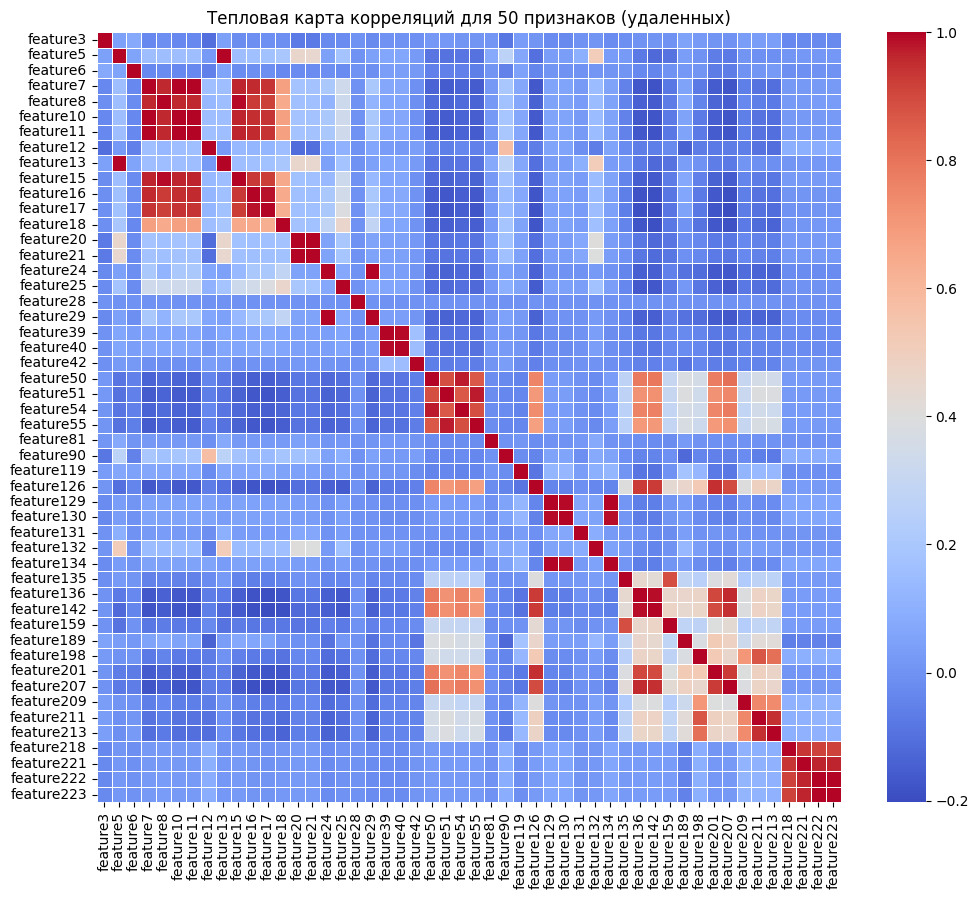

In [16]:
selected_features = correlated.columns[:50]
correlation_matrix = correlated[selected_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)

plt.title('Тепловая карта корреляций для 50 признаков (удаленных)')
plt.show()

In [7]:
df_no_corr = clean_df.drop(columns=corr_feats)

In [8]:
X = df_no_corr.copy()
X['target'] = data['target']
X = X.reset_index(drop=True)
X = X.drop(['feature642'], axis=1)

In [9]:
X['sin341'] = np.sin(X['feature341'])
X['log940'] = np.log1p(X['feature940'])
X['new1'] = (X['feature1004'] * X['feature994'])

In [20]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly_features = poly.fit_transform(X[['feature1004', 'feature318', 'feature341', 'feature994', 'feature952',
        'feature944', 'feature320', 'feature1000', 'feature943', 'feature993', 'new1', 'sin341', 'log940', 'feature341', 'feature940']])
poly_feature_names = [f'poly_{i}' for i in range(poly_features.shape[1])]
X_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

X = pd.concat([X, X_poly], axis=1)

In [21]:
X_train, X_val = train_test_split(X, random_state=42, shuffle=True, test_size=0.25, stratify=X['target'])

In [22]:
y_train = X_train['target'].values
new_X_train = X_train.drop(['target'], axis=1)

y_val = X_val['target'].values
new_X_val = X_val.drop(['target'], axis=1)

In [28]:
CatBoostModel = CatBoostClassifier(
    iterations= 100,
#     cat_features=cat_cols,
#     learning_rate = 0.05,
    use_best_model = True,
    eval_metric ='AUC', 
    loss_function='Logloss',
    random_seed = 42,
    verbose=100,
    early_stopping_rounds=100,
#     class_weights=[1., 10.]
#     logging_level = 'Silent',
)

In [29]:
CatBoostModel.fit(
    new_X_train, y_train,
    eval_set=(new_X_val, y_val),
    plot=False
)

Learning rate set to 0.37655
0:	test: 0.6534539	best: 0.6534539 (0)	total: 881ms	remaining: 1m 27s
99:	test: 0.7523470	best: 0.7529967 (64)	total: 1m 34s	remaining: 0us

bestTest = 0.7529966847
bestIteration = 64

Shrink model to first 65 iterations.


In [30]:
predictions_labels = CatBoostModel.predict(new_X_val)
predictions_probs = CatBoostModel.predict_proba(new_X_val)[:, 1]

In [31]:
print(f'Precision Score: {precision_score(y_val, predictions_labels)}')
print(f'Recall Score: {recall_score(y_val, predictions_labels)}')
print(f'F1 Score: {f1_score(y_val, predictions_labels)}')
print(f'ROC AUC Score: {roc_auc_score(y_val, predictions_probs)}')

Precision Score: 0.524390243902439
Recall Score: 0.00927924039706517
F1 Score: 0.01823579304495335
ROC AUC Score: 0.752996684692355


In [32]:
print(f'Количество 1 в тест: {Counter(y_val)}')
print(f'Количество 1 в предсказанном тесте: {Counter(predictions_labels)}')

Количество 1 в тест: Counter({0: 125270, 1: 4634})
Количество 1 в предсказанном тесте: Counter({0: 129822, 1: 82})


In [33]:
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

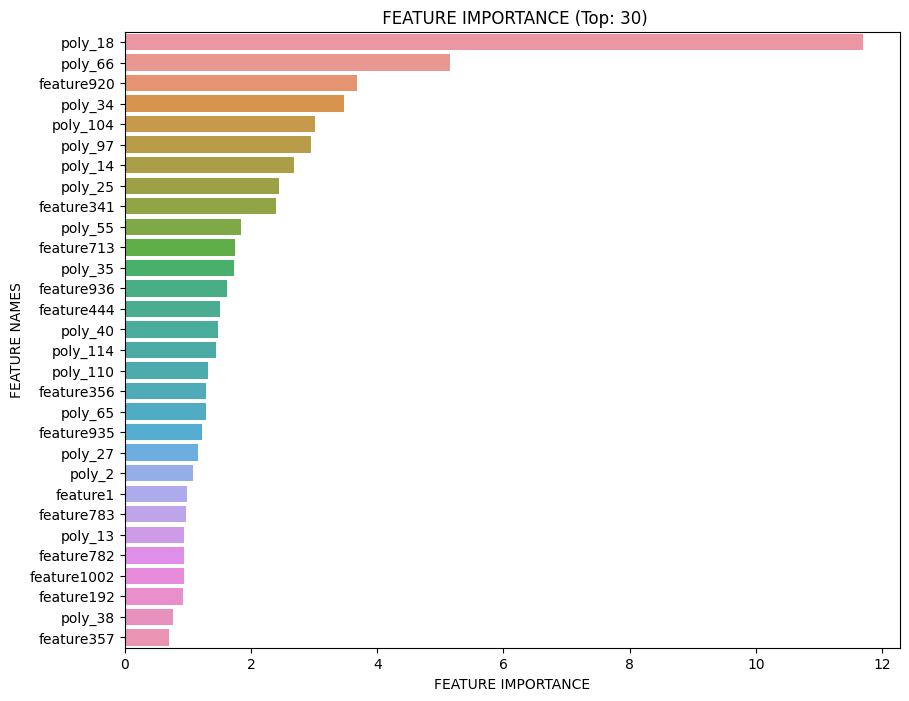

In [34]:
dfi = plot_feature_importance(CatBoostModel.get_feature_importance(), new_X_val.columns, top_n=30) 

In [35]:
def objective(trial):
    params = {
        "objective" : trial.suggest_categorical("objective", ["Logloss"]),
        "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-2, 3e0),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1, log = True),
        "depth" : trial.suggest_int("depth", 2, 5),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 2, 50, 4),
        "one_hot_max_size" : trial.suggest_int("one_hot_max_size", 2, 50, 4),
        "iterations" : trial.suggest_int("iterations", 500, 2000, 250),
        "eval_metric" : "AUC"
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log = True)

    model = cb.CatBoostClassifier(
        loss_function = 'Logloss',
        random_seed = 42,
        task_type = 'CPU',
        use_best_model = True,
        verbose = False,
        class_weights=[1., 2.],
        **params
    )

    model.fit(
        new_X_train, y_train,
        eval_set = (new_X_val, y_val)
    )

    y_pred = model.predict_proba(new_X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 3), direction = "maximize")
study.optimize(objective, n_trials = 100, timeout = 1800)

best_params = study.best_params

print("Best params:", best_params)

[I 2024-03-13 22:56:51,895] A new study created in memory with name: no-name-56520aa2-d9b4-44f0-87aa-b12970f35cea
[W 2024-03-13 22:57:00,884] Trial 0 failed with parameters: {'objective': 'Logloss', 'learning_rate': 0.0007345300351588762, 'l2_leaf_reg': 0.8839240130493983, 'colsample_bylevel': 0.010275456650049518, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 46, 'one_hot_max_size': 30, 'iterations': 500, 'bagging_temperature': 8.292563917119448} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_33/3378786699.py", line 31, in objective
    model.fit(
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, base

KeyboardInterrupt: 